# Dark Matter Analysis of the Brown Dwarf

This tutorial demonstrates how to perform an analysis of one Brown Dwarf (BD). This tutorial assumes that you know the basic analys methodology of Fermi-LAT and fermipy. In this example we will use the following data selection which is chosen to match the selection used in the [13-year LAT Dwarf Analysis](https://arxiv.org/abs/2211.08067). This analysis is performed on the fermipy version 1.0.1 and Fermi ScienceTools version 2.0.8. Before running this analysis, you need to activate the fermi by "conda activate fermi"

* 10x10 degree ROI
* Start Time (MET) = 239557417 seconds (2008-08-04)
* Stop Time (MET) = 661205870 seconds (2021-12-14)
* Minimum Energy = 100 MeV
* Maximum Energy = 500000 MeV
* zmax = 90 deg
* P8R3_SOURCE_V2 (evclass=128, evtype=3)

## Get the Data and Setup the Analysis

In this thread we will use a pregenerated data set of Brown Dwarf which is contained in a tar archive in the *data* directory. You can also generate the photons and spacecraft files by following the data_preparation tutorial.

In [5]:
%matplotlib inline
import os
import numpy as np
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
import matplotlib.pyplot as plt
import matplotlib

In [33]:
os.path.isfile('./data')

False

In [ ]:
We will download the spacecraft mission file directly from the FSSC FTP Server. Run this command to download the mission spacecraft file.

In [10]:
!wget -m -P . -nH --cut-dirs=4 -np -e robots=off https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/mission/spacecraft/

In [ ]:
cd ./mission/spacecraft
mv lat_spacecraft_merged.fits spacecraft.fits
cp spacecraft.fits ../../

Before proceeding, we will first check the contents of the configuration file written in .yaml format. Here, we set the coordinates of BD explicitly since the ROI center isn't at the position of a 4FGL source.

In [6]:
!cat test.yaml

logging : 

  verbosity : 3

data:

  evfile: binned_events.txt
  scfile: spacecraft.fits
  
binning:

  # Binning
  roiwidth   : 15.0
  npix       : null
  binsz      : 0.1 # spatial bin size in deg
  binsperdec : 8   # nb energy bins per decade
  coordsys   : 'GAL'

selection:

  # Data selections
  emin    : 100
  emax    : 500000
  zmax    : 90
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 661205870 # 13 years
  filter  : DATA_QUAL>0 && LAT_CONFIG==1
  roicut : no
  target : 'source_1'
  # Set the ROI center to these coordinates
  ra: 40.8071
  dec: -24.8917

gtlike:
  # IRFs
  edisp : True
  irfs : 'P8R3_SOURCE_V2'
  edisp_disable : ['isodiff','galdiff']

# Settings for ROI model
model:
  # Include catalog sources within a box of width roisrc.
  src_roiwidth : 20.0

  galdiff  : 'gll_iem_v07.fits'
  isodiff  : 'iso_P8R3_SOURCE_V3_v1.txt'

  # List of catalogs to be used in the model.
  catalogs : ['4FGL']

  sources  :
    - { name: 'source_1', ra : 40.8071, dec 

To get started we will first instantiate a GTAnalysis instance using the configuration file, i.e. test.yaml and the run the setup() method.  This will prepare all the ancillary files and create the pylikelihood instance for binned analysis.  Note that in this example these files have already been generated so the routines that would normally be executed to create these files will be skipped.

In [8]:
gta = GTAnalysis('test.yaml',logging={'verbosity' : 3})
matplotlib.interactive(True)
gta.setup()
gta.write_roi('fit0')

2023-01-06 22:43:30 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.0.1 
ScienceTools version 2.0.8
2023-01-06 22:43:31 INFO    GTAnalysis.setup(): Running setup.
2023-01-06 22:43:31 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-01-06 22:43:31 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-01-06 22:43:31 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/irfs.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  log_ratio = np.log(x[xs1] / x[xs0])
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/irfs.py:52: FutureWarning: Usin

## Print the ROI model

We can print the ROI object to see a list of sources in the model along with their distance from the ROI center (offset), TS, and number of predicted counts (Npred).  Since we haven't yet fit any sources, the ts of all sources will initially be assigned as nan.

In [9]:
gta.print_roi()

2023-01-06 22:46:32 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
source_1            PointSource    PowerLaw          0.000       nan         2.8
4FGL J0252.3-2707   PointSource    PowerLaw          3.033       nan      1375.2
4FGL J0252.8-2219   PointSource    LogParabola       3.380       nan     22975.0
4FGL J0225.1-2604   PointSource    PowerLaw          4.252       nan      5093.1
4FGL J0303.4-2407   PointSource    LogParabola       4.664       nan     11662.8
4FGL J0301.9-2731   PointSource    PowerLaw          4.967       nan      1211.4
4FGL J0235.6-2939   PointSource    PowerLaw          5.052       nan       252.8
4FGL J0304.4-2833   PointSource    PowerLaw          5.987       nan       226.4
4FGL J0238.4-3116   PointSource    PowerLaw          6.476       nan      1749.8
4FGL J0228.0-3026   PointSource    PowerLaw          6.4

We can assess the quality of our pre-fit model by running the residmap method.  This will generate four maps

2023-01-06 22:46:57 INFO    GTAnalysis.residmap(): Generating residual maps
2023-01-06 22:46:57 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2023-01-06 22:46:58 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2023-01-06 22:46:58 INFO    GTAnalysis.residmap(): Finished residual maps
2023-01-06 22:47:04 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/test_prefit_pointsource_powerlaw_2.00_residmap.npy
2023-01-06 22:47:04 INFO    GTAnalysis.residmap(): Execution time: 7.29 s
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/plotting.py:146: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cm

Text(0.5, 1.0, 'Excess')

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' paramete

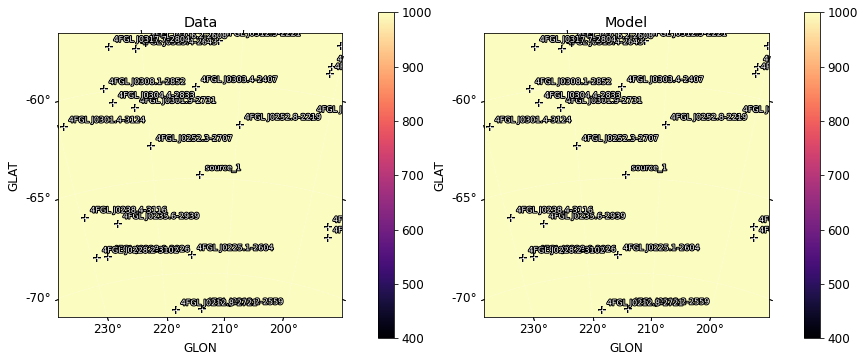

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' paramete

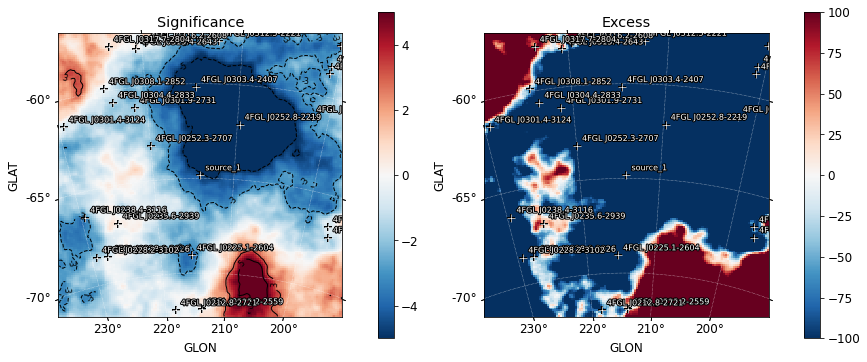

In [10]:
resid = gta.residmap('test_prefit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=400,vmax=1000,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=400,vmax=1000,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

Now we will run the *optimize* method.  This method will iteratively optimize the parameters of all components in the ROI in several stages:
* Simultaneously fitting the normalization of the brightest model components containing at least some fraction of the total model counts (default 95%).
* Individually fitting the normalization of all remaining sources if they have Npred above some threshold (default 1).
* Individually fitting the normalization and shape of any component with TS larger than some threshold (default 25).

Running *optimize* gives us a baseline model that we can use as a starting point for subsequent stages of the analysis.  We will also save the results of the analysis with write_roi.  By saving the analysis state we can restore the analysis to this point at any time with the *load_roi* method. (**NOTE**: This step is computationally intensive and can take up to 5-10 minutes)

In [11]:
gta.optimize()
gta.write_roi('fit1')

2023-01-06 22:47:35 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['isodiff', 'galdiff', '4FGL J0252.8-2219', '4FGL J0303.4-2407', '4FGL J0225.1-2604']


/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Fitting shape isodiff TS:  37216.155
Fitting shape 4FGL J0303.4-2407 TS:  12400.750
Fitting shape 4FGL J0252.8-2219 TS:  11731.711
Fitting shape galdiff TS:   1530.390
Fitting shape 4FGL J0238.4-3116 TS:   1326.348
Fitting shape 4FGL J0225.1-2604 TS:    696.870
Fitting shape 4FGL J0316.2-2608 TS:    590.424
Fitting shape 4FGL J0312.5-2221 TS:    317.299
Fitting shape 4FGL J0305.1-1608 TS:    155.833
Fitting shape 4FGL J0226.3-1845 TS:    127.088
Fitting shape 4FGL J0251.1-1830 TS:    123.997
Fitting shape 4FGL J0301.9-2731 TS:    113.531
Fitting shape 4FGL J0301.0-1652 TS:     96.077
Fitting shape 4FGL J0224.0-1850 TS:     95.123
Fitting shape 4FGL J0301.4-3124 TS:     94.155
Fitting shape 4FGL J0315.4-2643 TS:     91.375
Fitting shape 4FGL J0304.4-2833 TS:     90.464
Fitting shape 4FGL J0205.0-1700 TS:     80.267
Fitting shape 4FGL J0228.0-3026 TS:     78.847
Fitting shape 4FGL J0235.6-2939 TS:     74.705
Fitting shape 4FGL J0212.2-2559 TS:     67.225
Fitting shape 4FGL J0259.5-1705 T

2023-01-06 22:48:10 INFO    GTAnalysis.optimize(): Finished
2023-01-06 22:48:10 INFO    GTAnalysis.optimize(): LogLike: -187041.458823 Delta-LogLike: 766.847987
2023-01-06 22:48:10 INFO    GTAnalysis.optimize(): Execution time: 35.18 s
2023-01-06 22:48:10 INFO    GTBinnedAnalysis.write_xml(): Writing /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/fit1_00.xml...
2023-01-06 22:48:10 INFO    GTAnalysis.write_fits(): Writing /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/fit1.fits...
2023-01-06 22:48:30 INFO    GTAnalysis.write_roi(): Writing /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/fit1.npy...


After running *optimize* we can rerun *print_roi* to see a summary of the updated model.  All sources that were fit in this step now have ts values and an Npred value the reflects the optimized normalization of that source.  Note that model components that were not fit during the optimize step still have ts=nan.

In [12]:
gta.print_roi()

2023-01-06 22:48:30 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
source_1            PointSource    PowerLaw          0.000     -0.00         0.0
4FGL J0252.3-2707   PointSource    PowerLaw          3.033     32.24      1027.6
4FGL J0252.8-2219   PointSource    LogParabola       3.380  12778.60     18068.8
4FGL J0225.1-2604   PointSource    PowerLaw          4.252    741.10      3886.7
4FGL J0303.4-2407   PointSource    LogParabola       4.664  12682.15      9225.4
4FGL J0301.9-2731   PointSource    PowerLaw          4.967    113.15       865.0
4FGL J0235.6-2939   PointSource    PowerLaw          5.052     78.24       381.0
4FGL J0304.4-2833   PointSource    PowerLaw          5.987     93.43       231.5
4FGL J0238.4-3116   PointSource    PowerLaw          6.476   1359.48      1595.6
4FGL J0228.0-3026   PointSource    PowerLaw          6.4

To evaluate the quality of the optimized model we can rerun the residmap method.  In the updated residual map that we see that there is no longer a negative residual in the vicinity of J1707.

2023-01-06 22:51:33 INFO    GTAnalysis.residmap(): Generating residual maps
2023-01-06 22:51:33 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2023-01-06 22:51:34 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2023-01-06 22:51:35 INFO    GTAnalysis.residmap(): Finished residual maps
2023-01-06 22:51:41 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/test_postfit_pointsource_powerlaw_2.00_residmap.npy
2023-01-06 22:51:41 INFO    GTAnalysis.residmap(): Execution time: 7.52 s
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/plotting.py:146: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(c

Text(0.5, 1.0, 'Excess')

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' paramete

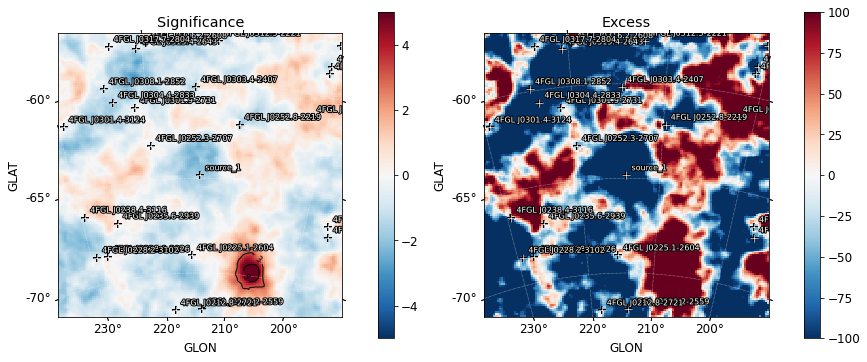

In [13]:
resid = gta.residmap('test_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

Another diagnostic for the quality of the ROI model is the TS map.  The *tsmap* method can be used to generate a TS map of the ROI with a given test source model.  Here we use the same source model we did for the residual map -- a point source with a power-law index of 2.  

In [14]:
tsmap_postfit = gta.tsmap('test_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2023-01-06 22:51:58 INFO    GTAnalysis.tsmap(): Generating TS map
2023-01-06 22:51:59 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2023-01-06 22:53:15 INFO    GTAnalysis.tsmap(): Finished TS map
2023-01-06 22:53:30 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/test_postfit_pointsource_powerlaw_2.00_tsmap.npy
2023-01-06 22:53:30 INFO    GTAnalysis.tsmap(): Execution time: 92.44 s


Here we see that the excess in the northeast part of the ROI appears more prominent than in the residual map.  This excess is detected as a new point source with TS > 25.

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/plotting.py:146: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  plt.register_cmap(name='ds9_b', data=ds9_b)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/plotting.py:301: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  colormap.set_under(colormap(0))
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated sin

Text(0.5, 1.0, 'NPred')

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' paramete

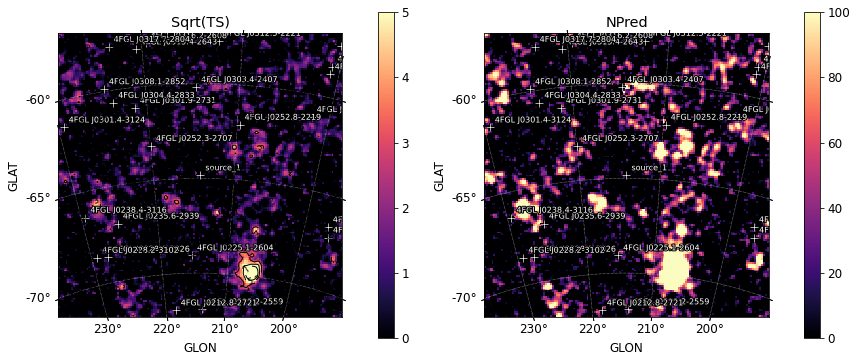

In [15]:
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_postfit['npred'],roi=gta.roi).plot(vmin=0,vmax=100,subplot=122,cmap='magma')
plt.gca().set_title('NPred')

We can add this source into the model by running the *find_sources* method.  This method will generate a TS map of the region and add a point-source at the location of each peak with TS > 25.

In [16]:
src = gta.find_sources()

2023-01-06 23:13:31 INFO    GTAnalysis.find_sources(): Starting.
2023-01-06 23:13:31 INFO    GTAnalysis.tsmap(): Generating TS map
2023-01-06 23:13:32 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2023-01-06 23:14:22 INFO    GTAnalysis.tsmap(): Finished TS map
2023-01-06 23:14:32 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/sourcefind_00_pointsource_powerlaw_2.00_tsmap.npy
2023-01-06 23:14:32 INFO    GTAnalysis.tsmap(): Execution time: 60.17 s
2023-01-06 23:14:32 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0218.7-2306
ts: 170.313873
2023-01-06 23:14:32 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0228.2-2232
ts: 26.364107
2023-01-06 23:14:32 INFO    GTAnalysis.add_source(): Adding source PS J0218.7-2306
2023-01-06 23:14:33 INFO

From the log we can see some new sources are added.  Rerunning the *tsmap* method we can see that this source is located at the peak of the TS Map.

2023-01-07 01:33:20 INFO    GTAnalysis.tsmap(): Generating TS map
2023-01-07 01:33:21 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2023-01-07 01:34:07 INFO    GTAnalysis.tsmap(): Finished TS map
2023-01-07 01:34:19 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/bhattachar/Desktop/work_with_francesca/lat_data/Brown Dwarf github/brown-dwarf/brown-dwarf/data_out/test_newsrcs_pointsource_powerlaw_2.00_tsmap.npy
2023-01-07 01:34:19 INFO    GTAnalysis.tsmap(): Execution time: 58.48 s
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/fermipy/plotting.py:146: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  plt.register_cmap(name='ds9_b', data=ds9_b)
/home/bhattachar/anaconda3/envs/

Text(0.5, 1.0, 'NPred')

/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/home/bhattachar/anaconda3/envs/fermi/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' paramete

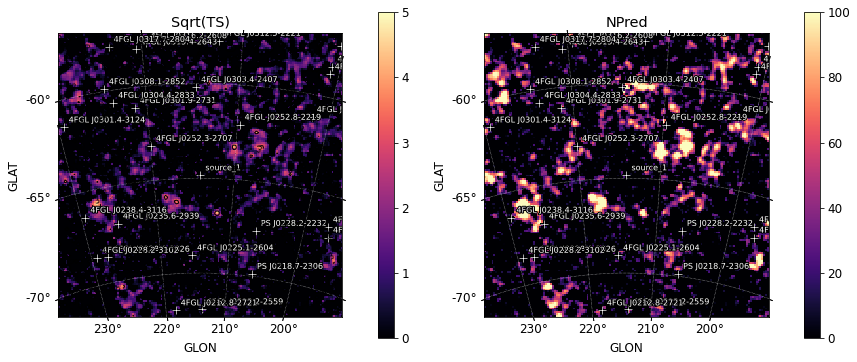

In [18]:
#print(gta.roi['PS J1705.4+5434'])
tsmap_newsrcs = gta.tsmap('test_newsrcs',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_newsrcs['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_newsrcs['npred'],roi=gta.roi).plot(vmin=0,vmax=100,subplot=122,cmap='magma')
plt.gca().set_title('NPred')

## Spectral Analysis

After optimizing the ROI model we are ready to perform our analysis of the source of interest.  We will begin by freeing our source along with all other point sources within 10 deg of the ROI center and refitting their normalizations.

In [20]:
gta.free_sources(distance=10.0,pars='norm')
gta.free_sources(distance=10.0,pars='shape',minmax_ts=[100.,None])
gta.free_source('source_1')
gta.free_source('galdiff')
gta.free_source('isodiff')
fit_results = gta.fit()

2023-01-07 01:34:53 INFO    GTAnalysis.free_source(): Freeing parameters for source_1              : ['Index']
2023-01-07 01:34:53 INFO    GTAnalysis.fit(): Starting fit.


Drm_Cache::update Measured counts < 0 4FGL J0252.8-2219 29 -1.18451e-14 1.20709e-13
356.214 626.595 915.886 1135.13 1222.24 1154.19 955.859 701.404 457.725 263.886 132.85 58.7853 22.9742 7.97266 2.47445 0.70093 0.176893 0.0398628 0.00804239 0.00145894 0.000240731 3.53576e-05 4.58741e-06 5.30021e-07 5.47632e-08 5.05594e-09 4.17883e-10 3.09381e-11 2.05042e-12 1.20709e-13 


2023-01-07 01:35:04 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   2 Status: 102
2023-01-07 01:35:04 INFO    GTAnalysis.fit(): LogLike:  -186908.869 DeltaLogLike:       26.383 


After running the fit completes we can execute the spectral analysis of our Brown Dwarf source.

In [23]:
sed_test = gta.sed('source_1')
gta.write_roi('fit_sed')

2023-01-07 01:37:27 INFO    GTAnalysis.sed(): Computing SED for source_1
2023-01-07 01:37:32 INFO    GTAnalysis._make_sed(): Fitting SED
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for source_1              : ['Index']
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0252.8-2219     : ['alpha', 'beta']
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0225.1-2604     : ['Index']
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0303.4-2407     : ['alpha', 'beta']
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0301.9-2731     : ['Index']
2023-01-07 01:37:32 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2023-01-07 01:37:39 INFO    GTAnalysis.sed(): Finished SED
2023-01-07 01:37:46 INFO    GTAnalysis.sed(): Execution time: 18.69 s
2023-01-07 01:37:46 INFO    GTBinnedAnalysis.write_xml(): 

We can now inspect the fit results by looking at the elements of the output dictionary.  By default the sed method will perform a likelihood scan in each energy bin which is saved in the *dloglike_scan* array.  In the following example we plot the likelihood profile in the first energy bin and overplot the flux upper limit in that bin (vertical black line).  fermiPy uses the delta-log-likelihood method to evaluate ULs and we can see that the 95% CL flux upper limit intersects with the point at which the log-likelihood has decreased by 2.71/2 from its maximum value (horizontal red line).

[8.54641222e-07 1.67013770e-07 3.20308215e-07 2.23597226e-07
 2.41836580e-07 1.27541778e-07 1.91664290e-07 1.01989370e-07
 2.09481161e-07 5.20064558e-08 6.66566489e-08 2.60271923e-07
 8.22186317e-08 8.99333342e-08 1.07898319e-07 9.63236557e-08
 4.66656388e-07 1.34845453e-07 1.94389889e-07 2.37057961e-07
 3.09927628e-07 3.98679430e-07 1.23176303e-06 7.09544851e-07
 9.43858238e-07 1.26489637e-06 4.46263729e-06 2.24788259e-06
 3.00941544e-06 4.36353294e-06]


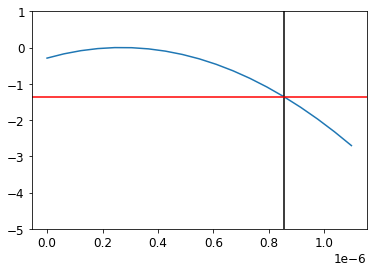

In [27]:
# E^2 x Differential flux ULs in each bin in units of MeV cm^{-2} s^{-1}
print (sed_test['e2dnde_ul95'])

e2dnde_scan = sed_test['norm_scan']*sed_test['ref_e2dnde'][:,None]

plt.figure()
plt.plot(e2dnde_scan[0],
        sed_test['dloglike_scan'][0]-np.max(sed_test['dloglike_scan'][0]))
plt.gca().set_ylim(-5,1)
plt.gca().axvline(sed_test['e2dnde_ul95'][0],color='k')
plt.gca().axhline(-2.71/2.,color='r')

We can also visualize the results of the scan with the SEDPlotter class.  This class accepts a source object as its argument and creates a visualization of the SED as a sequence of points with errors.  Setting showlnl=True overplots the likelihood function in each bin as a color gradient (the so-called castro plot).

(1e-08, 1e-05)

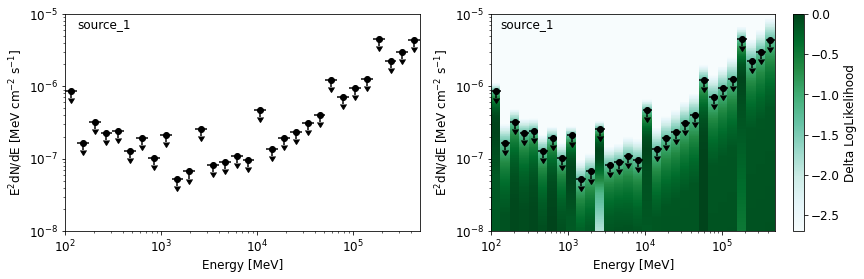

In [29]:
fig = plt.figure(figsize=(14,4))
ylim=[1E-8,1E-5]
fig.add_subplot(121)
SEDPlotter(sed_test).plot()
plt.gca().set_ylim(ylim)

fig.add_subplot(122)
SEDPlotter(sed_test).plot(showlnl=True,ylim=ylim)
plt.gca().set_ylim(ylim)

In [34]:
import numpy as np

c = np.load('./data_out/test_sed.npy', allow_pickle=True).flat[0]

e_ctr = (c['e_ctr'])
e2dnde = (c['e2dnde'])
e2dnde_ul95 = (c['e2dnde_ul95'])
eflux_ul95 = (c['eflux_ul95'])


outfile = open('flux_test.txt','w')
outfile.write('\t e_ctr \t\t e2dnde \t\t e2dnde_ul95 \t\t eflux_ul95\n')
for i in range(len(e_ctr)):
	outfile.write(str( str(e_ctr[i]) + '\t' + str(e2dnde[i]) + '\t' + str(e2dnde_ul95[i]) + '\t' +str(eflux_ul95[i]) ))
	outfile.write('\n')
outfile.close()